<a href="https://colab.research.google.com/github/abdheshdash8/Deconfounding-Recommender-Systems/blob/main/deconfounded_recommender1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class MFModel(nn.Module):
    def __init__(self, n_users, n_items, K=10):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, K)
        self.item_factors = nn.Embedding(n_items, K)
        self.bias = nn.Parameter(torch.tensor(0.0))
    def forward(self, u, i):
        pred = (self.user_factors(u) * self.item_factors(i)).sum(dim=1)
        return pred + self.bias


class DeconfMF(nn.Module):
    def __init__(self, n_users, n_items, K=10):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, K)
        self.item_factors = nn.Embedding(n_items, K)
        self.gamma = nn.Embedding(n_users, 1)
        self.bias = nn.Parameter(torch.tensor(0.0))
    def forward(self, u, i, tilde):
        pred = (self.user_factors(u) * self.item_factors(i)).sum(dim=1)
        pred = pred + (self.gamma(u).squeeze() * tilde)
        return pred + self.bias


In [ ]:
def run_experiment_for_gamma(gamma_strength, n_users=200, n_items=300, K=10, epochs=300, lr=0.01):
    """
    Run a single experiment for given confounding strength γθ.
    Returns test MSE for Baseline MF, IPW-MF, and Deconfounded MF.
    """

    # Synthetic data
    torch.manual_seed(0)
    np.random.seed(0)

    # Latent factors for true preference
    theta_true = torch.randn(n_users, K, dtype=torch.float32)
    beta_true = torch.randn(n_items, K, dtype=torch.float32)

    # True latent confounder z_u (user-level)
    z = torch.randn(n_users, 1, dtype=torch.float32)

    # Exposure model (biased by z)
    logits = torch.matmul(theta_true, beta_true.T) * 0.2 + gamma_strength * z @ torch.ones((1, n_items))
    prob = torch.sigmoid(logits)
    A = torch.bernoulli(prob).to(torch.float32)  # exposure

    # Generate true potential outcomes
    Y_true = torch.matmul(theta_true, beta_true.T) + 0.3 * z @ torch.ones((1, n_items)) + 0.1 * torch.randn(n_users, n_items)
    # Only observed if exposed
    Y_obs = Y_true * A

    # Create train/test splits
    train_mask = torch.rand_like(A) < 0.8
    test_mask = ~train_mask

    train_u, train_i = torch.where(train_mask)
    test_u, test_i = torch.where(test_mask)
    train_y = Y_obs[train_u, train_i]
    test_y_true = Y_true[test_u, test_i]

    # Convert to float32 tensors
    train_u = train_u.to(torch.long).to(device)
    train_i = train_i.to(torch.long).to(device)
    train_y = train_y.to(torch.float32).to(device)
    test_u = test_u.to(torch.long).to(device)
    test_i = test_i.to(torch.long).to(device)
    test_y_true = test_y_true.to(torch.float32).to(device)

    # IPW weights calculation
    # Logistic exposure probability estimation (simple heuristic)
    exposure_probs = (A.sum(dim=1, keepdim=True) + 1) / (A.sum() + 1)
    weights_ipw = 1.0 / torch.clamp(exposure_probs[train_u], min=1e-3)

    # The substitute confounder (NMF on exposure)
    from sklearn.decomposition import NMF
    nmf = NMF(n_components=K, init='nndsvda', max_iter=2000, random_state=0)
    W = torch.tensor(nmf.fit_transform(A.numpy()), dtype=torch.float32)
    H = torch.tensor(nmf.components_.T, dtype=torch.float32)
    A_tilde = torch.matmul(W, H.T)
    train_tilde = A_tilde[train_u, train_i].to(device)

    ### Training the 3 models
    mse_fn = nn.MSELoss()

    # (a) Baseline MF
    mf = MFModel(n_users, n_items, K).to(device)
    opt = torch.optim.Adam(mf.parameters(), lr=lr)
    for _ in range(epochs):
        opt.zero_grad()
        pred = mf(train_u, train_i)
        loss = mse_fn(pred, train_y)
        loss.backward()
        opt.step()

    with torch.no_grad():
        test_pred_b = mf(test_u, test_i)
        mse_b = mse_fn(test_pred_b, test_y_true).item()

    # (b) IPW-MF
    mf_ipw = MFModel(n_users, n_items, K).to(device)
    opt = torch.optim.Adam(mf_ipw.parameters(), lr=lr)
    for _ in range(epochs):
        opt.zero_grad()
        pred = mf_ipw(train_u, train_i)
        loss = (weights_ipw.squeeze().to(device) * (pred - train_y) ** 2).mean()
        loss.backward()
        opt.step()

    with torch.no_grad():
        test_pred_i = mf_ipw(test_u, test_i)
        mse_i = mse_fn(test_pred_i, test_y_true).item()

    # (c) Deconfounded MF
    mf_dc = DeconfMF(n_users, n_items, K).to(device)
    opt = torch.optim.Adam(mf_dc.parameters(), lr=lr)
    for _ in range(epochs):
        opt.zero_grad()
        pred = mf_dc(train_u, train_i, train_tilde)
        loss = mse_fn(pred, train_y)
        loss.backward()
        opt.step()

    with torch.no_grad():
        test_pred_d = mf_dc(test_u, test_i, A_tilde[test_u, test_i].to(device))
        mse_d = mse_fn(test_pred_d, test_y_true).item()

    return mse_b, mse_i, mse_d


In [ ]:
gamma_vals = np.linspace(0.0, 1.0, 10)
mse_b_list, mse_i_list, mse_d_list = [], [], []

for g in tqdm(gamma_vals):
    mb, mi, md = run_experiment_for_gamma(g)
    mse_b_list.append(mb)
    mse_i_list.append(mi)
    mse_d_list.append(md)


100%|██████████| 10/10 [02:29<00:00, 14.95s/it]


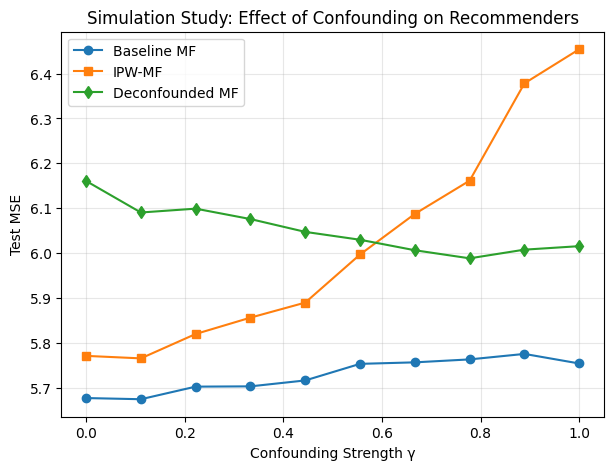

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(gamma_vals, mse_b_list, 'o-', label='Baseline MF')
plt.plot(gamma_vals, mse_i_list, 's-', label='IPW-MF')
plt.plot(gamma_vals, mse_d_list, 'd-', label='Deconfounded MF')
plt.xlabel('Confounding Strength γ')
plt.ylabel('Test MSE')
plt.title('Simulation Study: Effect of Confounding on Recommenders')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
